In [1]:
import pandas as pd
import jsonlines
import numpy as np
import scipy
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline

plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['font.size'] = 16

First, we'll read the data in from a (huge!) CSV file. We'll soon work things down to a more tractable size.

In [3]:
ints = pd.read_csv('/Volumes/LittleJim/Datasets/goodreads/goodreads_interactions.csv')

In [4]:
ints.head()

,user_id,book_id,is_read,rating,is_reviewed
0,0,948,1,5,0
1,0,947,1,5,1
2,0,946,1,5,0
3,0,945,1,5,0
4,0,944,1,5,0


In [5]:
ints.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228648342 entries, 0 to 228648341
Data columns (total 5 columns):
 #   Column       Dtype
---  ------       -----
 0   user_id      int64
 1   book_id      int64
 2   is_read      int64
 3   rating       int64
 4   is_reviewed  int64
dtypes: int64(5)
memory usage: 8.5 GB


Out dataset has five numeric columns: `user_id`, `book_id`, `is_read`, `rating`, and `is_reviewed`, which is a boolean flag indicating whether the user also left a review in addition to rating the book. According to the documentation at the [UCSD Book Graph](https://sites.google.com/eng.ucsd.edu/ucsdbookgraph/shelves?authuser=0), a user rating of zero means "not provided."

In [6]:
ints.head()

,user_id,book_id,is_read,rating,is_reviewed
0,0,948,1,5,0
1,0,947,1,5,1
2,0,946,1,5,0
3,0,945,1,5,0
4,0,944,1,5,0


In [7]:
ints.describe()

,user_id,book_id,is_read,rating,is_reviewed
count,2.286483e+08,2.286483e+08,2.286483e+08,2.286483e+08,2.286483e+08
mean,2.500636e+05,2.015756e+05,4.904090e-01,1.801340e+00,7.093491e-02
std,1.712713e+05,3.448677e+05,4.999080e-01,2.072672e+00,2.567161e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.143010e+05,1.252700e+04,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.338990e+05,5.034600e+04,0.000000e+00,0.000000e+00,0.000000e+00
75%,3.581100e+05,2.229240e+05,1.000000e+00,4.000000e+00,0.000000e+00
max,8.761440e+05,2.360649e+06,1.000000e+00,5.000000e+00,1.000000e+00


No missing values or non-positive integer values (such as missing values coded as -1). We have nearly 229M records.

To help with memory management, we'll change the dtypes based on these ranges. The ids will fit into 32-bit unsigned integers.

In [8]:
ints = ints.astype({'user_id': np.uint32,
                    'book_id': np.uint32,
                    'is_read': np.bool_,
                    'rating': np.uint8,
                    'is_reviewed': np.bool_,
                   })

In [9]:
ints.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228648342 entries, 0 to 228648341
Data columns (total 5 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   user_id      uint32
 1   book_id      uint32
 2   is_read      bool  
 3   rating       uint8 
 4   is_reviewed  bool  
dtypes: bool(2), uint32(2), uint8(1)
memory usage: 2.3 GB


In [10]:
ints.describe()

,user_id,book_id,rating
count,2.286483e+08,2.286483e+08,2.286483e+08
mean,2.500636e+05,2.015756e+05,1.801340e+00
std,1.712713e+05,3.448677e+05,2.072672e+00
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.143010e+05,1.252700e+04,0.000000e+00
50%,2.338990e+05,5.034600e+04,0.000000e+00
75%,3.581100e+05,2.229240e+05,4.000000e+00
max,8.761440e+05,2.360649e+06,5.000000e+00


Still big, but workable! Let's remove any duplicates.

In [11]:
ints = ints.drop_duplicates()

How many users are there? How many books? How many of our interactions records are *not* ratings?

In [12]:
print("Number of unique users:", ints['user_id'].unique().shape)
print("Number of unique books:", ints['book_id'].unique().shape)
n_nonrating_ints = ints[ints['rating'] == 0].shape
print("Number of non-rating interactions", n_nonrating_ints)
print("% of non-rating interactions", n_nonrating_ints[0] / ints.shape[0] * 100)

Number of unique users: (876145,)
Number of unique books: (2360650,)
Number of non-rating interactions (124096793, 5)
% of non-rating interactions 54.27408391179149


So just over half of the interactions are not ratings; the `is_read` interactions may still be useful, so we'll hold onto them. However, collaborative filtering on ratings alone will reduce our dataset by just over half.

An important decision in collaborative filtering is how many ratings per user we'll need for the ratings to rise above the level of noise. A rule of thumb can be that we want the correctness of our predictions to be statistically significant at some level. Let's look at the distribution of the number of ratings per user.

In [13]:
n_ratings = ints[ints['rating'] != 0].groupby('user_id')['rating'].count()
n_ratings.describe()

count    816371.000000
mean        128.068671
std         237.981617
min           1.000000
25%          22.000000
50%          55.000000
75%         141.000000
max       38884.000000
Name: rating, dtype: float64

We have 816,000 users with at least one rating. The number of ratings per user is *very* right-skewed, which is to be expected. Let's plot this, too.

In [14]:
n_ratings

user_id
0         473
1          99
2         191
3          41
4         176
         ... 
876140     11
876141     11
876142     32
876143     23
876144     37
Name: rating, Length: 816371, dtype: int64

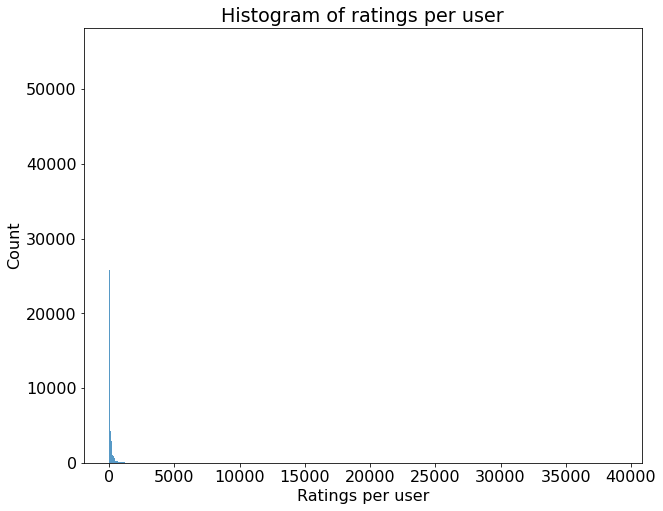

In [15]:
sns.histplot(n_ratings, kde=False)
plt.xlabel('Ratings per user')
plt.title('Histogram of ratings per user');

This is hard to read; the log transform of the number of readings will be easier to interpret:

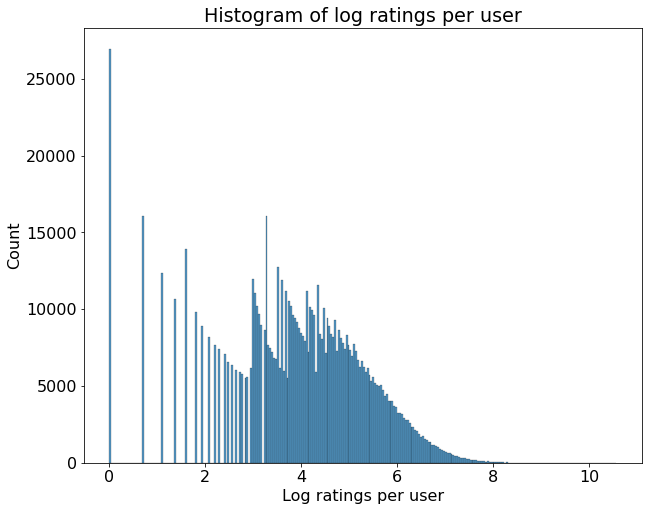

In [16]:
sns.histplot(np.log(n_ratings), kde=False)
plt.xlabel('Log ratings per user')
plt.title('Histogram of log ratings per user');

We can lose the long tail without removing very many values: exp(7) is about three standard deviations above the mean. We can decide how much of the left side to keep based on performance; we would expect performance to decline for sparser users.

How about ratings per book?

In [17]:
n_book_ratings = ints[ints['rating'] != 0].groupby('book_id')['rating'].count()
n_book_ratings.describe()

count    2.325541e+06
mean     4.495795e+01
std      8.255845e+02
min      1.000000e+00
25%      2.000000e+00
50%      4.000000e+00
75%      1.300000e+01
max      2.811350e+05
Name: rating, dtype: float64

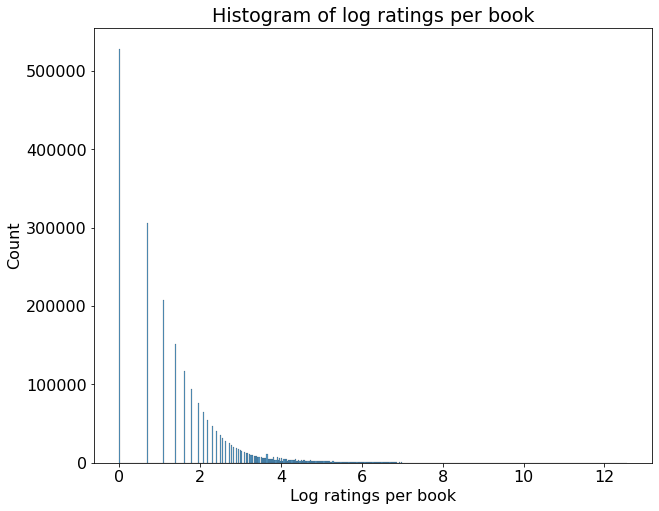

In [18]:
sns.histplot(np.log(n_book_ratings), kde=False)
plt.xlabel('Log ratings per book')
plt.title('Histogram of log ratings per book');

As expected, these have a very long tail as well. We'll keep these for now but will at least try setting a minimum number of ratings to improve performance. We'll also need to be careful to consider which algorithms bias popular books or prolific raters and, when so, whether to control for these in our modeling.

In [21]:
ints = ints.set_index('book_id').merge(n_book_ratings.rename('n_book_ratings'), how='left', left_index=True, right_index=True, copy=False).reset_index()
ints = ints.set_index('user_id').merge(n_ratings.rename('n_ratings'), how='left', left_index=True, right_index=True, copy=False).reset_index()

In [22]:
ints = ints.fillna({'n_ratings': 0, 'n_book_ratings': 0})

In [23]:
ints = ints.astype({
    'n_ratings': np.uint32,
    'n_book_ratings': np.uint64
})

In [24]:
ints.head()

,user_id,book_id,is_read,rating,is_reviewed,n_book_ratings,n_ratings
0,0,0,False,0,False,14,473
1,0,1,False,0,False,19,473
2,0,2,False,0,False,1,473
3,0,3,False,0,False,514,473
4,0,4,False,0,False,4,473


The dataset comes with some metadata as well; these don't provide much by way of augmentation. It does provide author ids, which may be useful in modeling. Unfortunately, the metadata is in a rather inconvenient (for our purposes) nested json; let's pull out any data we might use and save it as a CSV.

In [25]:
keys = ['isbn', 'title', 'url', 'image_url', 'book_id', 'authors']
read_filename = '/Volumes/LittleJim/Datasets/goodreads/goodreads_books.json'
write_filename = '/Volumes/LittleJim/Datasets/goodreads/goodreads_books_selected.csv'

In [26]:
def books_json_to_csv_extract(keys, read_filename, write_filename, mode='a', chunk=100000):
    c, t = 0, 0
    lines = []
    with jsonlines.open(read_filename) as reader:
        for obj in reader:
            selected = []
            for k in keys:
                if k in obj:
                    if k == 'authors':
                        result = get_first_author(obj[k])
                    else:
                        result = obj[k].replace('\t', ' ')
                else:
                    result = -1
                selected.append(result)
            lines.append('\t'.join(selected) + '\n')
            if c == chunk:
                c = 0
                print(t, lines[-1])
                with open(write_filename, mode) as writer:
                    writer.writelines(lines)
                lines = []
            c += 1
            t += 1
    return None

def get_first_author(authors_list_of_dicts):
    if authors_list_of_dicts and authors_list_of_dicts != -1:
        return authors_list_of_dicts[0]['author_id']
    return '-1'

In [27]:
# books_json_to_csv_extract(keys, read_filename, write_filename)  # We only need to do this once.

In [28]:
books_columns = ['isbn', 'title', 'url', 'image_url', 'book_id', 'author_id']
books_dtypes = {'isbn': 'str',
                'title': 'str',
                'url': 'str',
                'image_url': 'str',
                'book_id': 'Int64',
                'author_id': 'Int64',
               }

books_meta = pd.read_csv('/Volumes/LittleJim/Datasets/goodreads/goodreads_books_selected.csv', sep='\t', header=None, index_col=False, names=books_columns, dtype=books_dtypes, na_values=-1)

In [29]:
books_meta.head()

,isbn,title,url,image_url,book_id,author_id
0,0312853122,W.C. Fields: A Life on Film,https://www.goodreads.com/book/show/5333265-w-...,https://images.gr-assets.com/books/1310220028m...,5333265,604031
1,0743509986,Good Harbor,https://www.goodreads.com/book/show/1333909.Go...,https://s.gr-assets.com/assets/nophoto/book/11...,1333909,626222
2,NaN,"The Unschooled Wizard (Sun Wolf and Starhawk, ...",https://www.goodreads.com/book/show/7327624-th...,https://images.gr-assets.com/books/1304100136m...,7327624,10333
3,0743294297,Best Friends Forever,https://www.goodreads.com/book/show/6066819-be...,https://s.gr-assets.com/assets/nophoto/book/11...,6066819,9212
4,0850308712,Runic Astrology: Starcraft and Timekeeping in ...,https://www.goodreads.com/book/show/287140.Run...,https://images.gr-assets.com/books/1413219371m...,287140,149918


Finally, these `book_id` values are the internal *Goodreads* ids; they don't match the `book_id` in the interactions dataset. We must also load the mapping of `book_id` values in the interactions dataset to the `book_id` values in the metadata.

In [30]:
books_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2297147 entries, 0 to 2297146
Data columns (total 6 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   isbn       object
 1   title      object
 2   url        object
 3   image_url  object
 4   book_id    Int64 
 5   author_id  Int64 
dtypes: Int64(2), object(4)
memory usage: 109.5+ MB


In [31]:
book_id_map = pd.read_csv('/Volumes/LittleJim/Datasets/goodreads/book_id_map.csv').set_index('book_id')
book_id_map.head()

,book_id_csv
book_id,
34684622,0
34536488,1
34017076,2
71730,3
30422361,4


We'll add this mapping to the metadata:

In [32]:
books_meta = books_meta.set_index('book_id')
books_meta['book_id_csv'] = book_id_map['book_id_csv'].copy()
books_meta = books_meta.dropna(subset=['book_id_csv'])
books_meta['book_id_csv'] = books_meta['book_id_csv'].astype(np.uint64)
books_meta = books_meta.reset_index()

In [33]:
books_meta.head()

,book_id,isbn,title,url,image_url,author_id,book_id_csv
0,5333265,0312853122,W.C. Fields: A Life on Film,https://www.goodreads.com/book/show/5333265-w-...,https://images.gr-assets.com/books/1310220028m...,604031,1950356
1,1333909,0743509986,Good Harbor,https://www.goodreads.com/book/show/1333909.Go...,https://s.gr-assets.com/assets/nophoto/book/11...,626222,2084644
2,7327624,NaN,"The Unschooled Wizard (Sun Wolf and Starhawk, ...",https://www.goodreads.com/book/show/7327624-th...,https://images.gr-assets.com/books/1304100136m...,10333,740362
3,6066819,0743294297,Best Friends Forever,https://www.goodreads.com/book/show/6066819-be...,https://s.gr-assets.com/assets/nophoto/book/11...,9212,14854
4,287140,0850308712,Runic Astrology: Starcraft and Timekeeping in ...,https://www.goodreads.com/book/show/287140.Run...,https://images.gr-assets.com/books/1413219371m...,149918,979469


Finally, we'll save our transformed data and metadata:

In [34]:
ints.to_hdf('goodreads_interactions_preprocessed.h5', key='ints', mode='w')
books_meta.to_csv('goodreads_interactions_metadata_preprocessed.csv.gz')